In [2]:
from torchvision.transforms import ToTensor
from datasets import Dataset,DatasetDict
from torch.utils.data import DataLoader
from torchvision import datasets
from pathlib import Path
from torch import nn
import kaggle
import matplotlib.pyplot as plt
import torch
import numpy
import os
import pandas as pd

In [3]:
pd.set_option('display.width', 140)

# Setting up and getting the data ready

First we need to download the dataset from Kaggle.
Get your `kaggle.json` from from Kaggle's website and place it in `User/{name}/.kaggle` then install the Kaggle library.

```bash
pip install kaggle
```

In [4]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

creds = ''
cred_path = Path('./data/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

path = Path('titanic')

if not iskaggle and not path.exists():
    import zipfile
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Let's check our data

In [5]:
ls {path}

gender_submission.csv  test.csv               train.csv


In [6]:
dataframe = pd.read_csv(path/'train.csv')
dataframe

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Data Cleaning

First let's take a look at number of missing values in each column.

In [7]:
dataframe.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We solve this missing value problem by replacing the NAN values with either the **Mean**/ **Median** / **Mode**

### **1. Mean**
- **What It Is**: The average of all numbers.
- **Formula**: $ \text{Mean} = \frac{\text{Sum of all values}}{\text{Number of values}} $
- **Example**:
  - Data: $ [2, 4, 6, 8] $
  - Mean: $ \frac{2 + 4 + 6 + 8}{4} = 5 $

### **2. Median**
- **What It Is**: The middle value when the data is sorted.
- **How to Find**:
  - If odd number of values: Middle value.
  - If even number of values: Average of the two middle values.
- **Example**:
  - Data: $ [2, 4, 6, 8] $ (sorted)
  - Median: $ \frac{4 + 6}{2} = 5 $

### **3. Mode**
- **What It Is**: The most frequently occurring value in the data.
- **Example**:
  - Data: $ [2, 4, 4, 6, 8] $
  - Mode: $ 4 $ (appears twice, more than any other number).

For this example, we are going to use the mode for the missing values.

Let's check the mode for each column.

In [8]:
# iloc is a Pandas function used for integer-location based indexing .
# It allows you to select rows or columns by their integer position (index).
mode = dataframe.mode().iloc[0] # Selects the first row of the DataFrame.
mode

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

So here we can replace the missing values for age with `24` and cabin with `B96` and `B98` and embarked with `S`

We can use pandas `fillna` function to automatically fill in the missing values by their `mode`. Panda is smart to match the missing values for each column by itself.

We are also using `inplace=True` so the dataframe will be edited in place instead of returning a new one.

In [9]:
dataframe.fillna(mode, inplace=True)
dataframe.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

Let's take a look at our numeric values so have an understanding of our dataset.

In [10]:
dataframe.describe(include=(numpy.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now we see Fare is kind of interesting as it has lots of small numbers and some big numbers. There are some types of models which do not like [long-tale distribution](00_what_is_what.ipynb#long-tail_distribution).

To find out what's going on there we can use histogram to have a clearer view.

<Axes: >

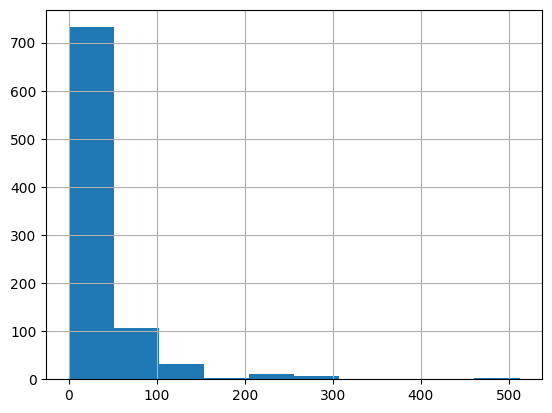

In [11]:
dataframe['Fare'].hist()

As you can see a large number of fare fall below 50 while a small amount above 500.

Luckily there is a very good way to turn the long-tail into a more reasonably centered distribution and that is to take the log (Logarithm).

We use logs a lot in machine learning, so it's really important to know how it works.

Logarithms help "compress" the scale of the data, making large values smaller while keeping small values relatively unchanged. This reduces the impact of extreme values (the "long tail") and makes the data more balanced.

Now we know that log of $0$ is **NaN**, the usual trick to avoid that is to add $+1$ to our log output. For that we can use `log1p` of `numpy`.

In [12]:
dataframe["LogFare"] = dataframe["Fare"].apply(numpy.log1p)

<Axes: >

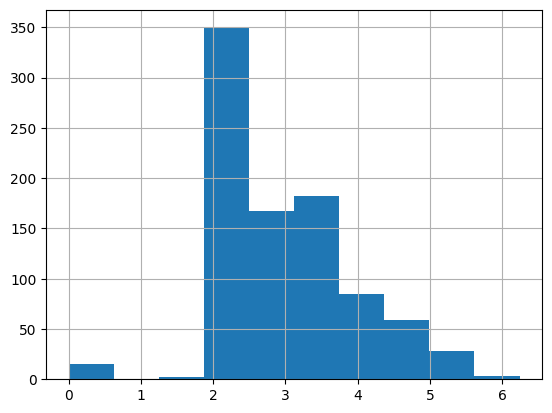

In [13]:
dataframe["LogFare"].hist()

> As a rule of thumb, things like money or population, things that can grow exponentially we very often want to take their logs.

Now we can describe our non numeric values to see which ones need to be converted to numeric values.

In [14]:
dataframe.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


In Pandas, the get_dummies() function converts categorical variables into dummy/indicator variables (known as one-hot encoding). This method is especially useful when preparing data for machine learning algorithms that require numeric input.

The function returns a DataFrame where each unique category in the original data is converted into a separate column, and the values are represented as True (for presence) or False (for absence).

In [15]:
# dtype=int converts boolean values to 0 and 1.
dataframe = pd.get_dummies(dataframe, columns=['Sex', 'Embarked', 'Pclass'], dtype=int)
dataframe.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [16]:
added_columns = ['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
dataframe[added_columns].head()

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,1,0,0,1,0,0,1
1,1,0,1,0,0,1,0,0
2,1,0,0,0,1,0,0,1
3,1,0,0,0,1,1,0,0
4,0,1,0,0,1,0,0,1


For this tutorial purposes we don't do anything with the names, so we don't use that column, but that's not always the case, we can sometimes get a better prediction by using objects like that. To learn more about that, study [tabular feature engineering](https://www.nvidia.com/en-us/on-demand/session/gtcspring23-dlit51195/).

Now we have to divide our dependent and independent variable.

**•	Independent Tensor (Features):** These are the input variables or features used to make predictions. Each column in your data representing these features is an independent tensor. They are called “independent” because they are not influenced by other variables in your dataset.

**•	Dependent Tensor (Target/Label):** This is the output variable that you want to predict. It’s dependent on the values of the independent variables. Essentially, the dependent tensor is what you’re trying to predict or explain using the independent tensors.

In [17]:
from torch import tensor

dependent_tensor = tensor(dataframe.Survived)

To create our independent variable, we use the new columns we've created from object type to numeric type and convert all the column types to float to make sure they are all the same type.

In [18]:
independent_columns = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_columns

independent_tensor = tensor(dataframe[independent_columns].values, dtype=torch.float)
independent_tensor

tensor([[22.,  1.,  0.,  ...,  0.,  0.,  1.],
        [38.,  1.,  0.,  ...,  1.,  0.,  0.],
        [26.,  0.,  0.,  ...,  0.,  0.,  1.],
        ...,
        [24.,  1.,  2.,  ...,  0.,  0.,  1.],
        [26.,  0.,  0.,  ...,  1.,  0.,  0.],
        [32.,  0.,  0.,  ...,  0.,  0.,  1.]])

In [19]:
independent_tensor.shape

torch.Size([891, 12])

The length of the tensor so called **[Rank](01_Intro.ipynb#ranks_in_pytorch)** is the number of dimensions or axis that it has.

Our independent tensor is rank 2 which is a matrice.

In [20]:
len(independent_tensor.shape)

2

## Setting up a [Linear Model](optional_read.ipynb#linear-model)

We generate random coefficients (weights) for each feature in our dataset. These coefficients will later be used to simulate a linear relationship between the independent variables (features) and a target value.

we generate random coefficients, one for each feature, therefor we have to use `independent_tensor.shape[1]` to get the number of columns (features):

In [21]:
torch.manual_seed(442)  # Set a random seed for reproducibility

n_coeff = independent_tensor.shape[1]  # Get the number of features (columns) in the dataset
coeffs = torch.rand(n_coeff) - 0.5  # Generate random coefficients between -0.5 and 0.5
coeffs  # These coefficients will be used to simulate a linear relationship with the features

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625])

We can check how our prediction output will perform by element-wise multiplication.

The line below multiplies each feature in `independent_tensor` by its corresponding coefficient in `coeffs`. Since `coeffs` is a 1D tensor, PyTorch [broadcasts](optional_read.ipynb#broadcasting) it across all rows, treating it as if it had the same shape as `independent_tensor`. This scales each feature according to its assigned coefficient.

In [22]:
independent_tensor*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.1096,   0.1386,   0.4818,  ...,  -0.0000,   0.0000,   0.3625],
        [-12.0354,   0.0000,   0.0000,  ...,  -0.4392,   0.0000,   0.0000],
        [-14.8128,   0.0000,   0.0000,  ...,  -0.0000,   0.0000,   0.3625]])

As we can see, the first column, has significantly larger values than the rest of the columns.

It is not ideal to have such a difference in our dataset as it makes the optimization much harder. So we'd like to all the columns to have about the same range values.

To fix that we need to [normalize](data_cleaning.ipynb#data_normalizing) these values. Dus, one way we can normalize is to divide these numbers by the maximum of each rows using [element-wise division](math.ipynb#element-wise-multiplication). As PyTorch tensors are basically vectors so it does that automatically in a very efficient C language level for us.

In [23]:
vals,indicies = independent_tensor.max(dim=0) # Get the max value and index for each column (feature) `dim=0` across all rows.
independent_tensor = independent_tensor / vals # Perform element-wise division of the tensor by the max value for each column.

Let's check our result again:

In [24]:
independent_tensor*coeffs

tensor([[-0.1273,  0.0173,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1389,  0.0173,  0.0803,  ..., -0.0000,  0.0000,  0.3625],
        [-0.1504,  0.0000,  0.0000,  ..., -0.4392,  0.0000,  0.0000],
        [-0.1852,  0.0000,  0.0000,  ..., -0.0000,  0.0000,  0.3625]])

We can see now we have pretty much similiar range values.

Now let's make our first prediction based on our coefficients (weights) by adding the `coeffs` up over the columns.

In [25]:
prediction = (independent_tensor*coeffs).sum(axis=1) # Perform a dot product of the tensor and the coefficients, axis=1 is the columns.
prediction[:10]

tensor([ 0.1412, -0.5725,  0.1494, -0.7523,  0.0453,  0.1411, -0.9302,  0.2961,
         0.2128,  0.2464])

Now we want to use Gradient Decent to make these predictions better. To do that we need a loss function to measure how good or bad are these coefficients.

[MAE](math.ipynb#mae) is many times a go to loss function.

In [26]:
loss = torch.abs(prediction - dependent_tensor).mean() # Calculate the mean absolute error between the prediction and the dependent tensor.
loss

tensor(0.6020)

Or we can use PyTorch function to do that.

In [27]:
import torch.nn as nn 

# use L1Loss() method to create a criterion  
# to measure the mean absolute error. 
MAE = nn.L1Loss()

# compute the mean absolute error 
output_tensor = MAE(prediction, dependent_tensor)
output_tensor

tensor(0.6020)

To make things clear, let's organize our code by putting them into functions.

In [28]:
def calc_prediction(coeffs, independent_values): 
  return (independent_values*coeffs).sum(axis=1)

def calc_loss(coeffs, independent, dependent): 
  return torch.abs(calc_prediction(coeffs=coeffs, independent_values=independent) - dependent).mean()

# Gradient Decent

First our weights (Coefficients) need to to be flagged as `require_grad` to PyTorch can track the gradient calculations for each weight.

In [29]:
# In PyTorch when there is an underscrore at the end of a method name, it means that the method will modify the object in-place.
coeffs.requires_grad_() # Enable gradient tracking for the coefficients tensor.

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,
         0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

Now when we calculate our loss, it doesn't do any calculation it's the same as before, but what it does store, is the gradient function. A function that PyTorch will remember to what it has to do to undo those gradients.

We can see the `grad_fn` function storing backward values. And later we can access it by `backward()` function.

In [30]:
loss = calc_loss(coeffs, independent_tensor, dependent_tensor)
loss

tensor(0.6020, grad_fn=<MeanBackward0>)

In [33]:
loss.backward() # Compute the gradients of the loss with respect to the coefficients.

At this point, the gradient calculation sticks to the `.grad` attribute and we can see the calculated gradient.

In [34]:
coeffs.grad

tensor([-0.1019,  0.0070, -0.0082, -0.1458, -0.1886,  0.0191, -0.0786,  0.0101,
        -0.1010, -0.2424, -0.1706,  0.2435])

So this tells us, that if we increase the age coefficient, the loss will go down! So therefor we should do that.

Now let's do that manually without having a learning rate set just to see what happens for demonstration purpose.

In [ ]:
with torch.no_grad():
  # Update weights
  coeffs.sub_(coeffs.grad * 0.1)
  print(calc_loss(coeffs, independent_tensor, dependent_tensor))

tensor(0.5794)


As we can see the loss went down a bit, that's great! Now we have everything we need to train a linear model.

First thing we need to do is to have a training and a validation set from our dataset, this way we can evaluate if our model is any good.

In [ ]:
# Split the data into training and validation sets using numpy
length_of_data = len(dataframe)
shuffled_indices = numpy.random.permutation(length_of_data)
train_indices = shuffled_indices[:int(0.8*length_of_data)]
val_indices = shuffled_indices[int(0.8*length_of_data):]

712 179


In [38]:
train_independent = independent_tensor[train_indices]
validation_independent = independent_tensor[val_indices]

train_dependent = dependent_tensor[train_indices]
validation_dependent = dependent_tensor[val_indices]

len(train_independent), len(validation_independent)

(712, 179)

Now let's put things into function to organize the code in a more readable manner.

In [39]:
# Updating the weights.
def update_coeffs(coeffs, lr): coeffs.sub_(coeffs.grad * lr)

In [54]:
# One epoch of training.
def one_epoch(coeffs, lr):
  loss = calc_loss(coeffs, train_independent, train_dependent)
  loss.backward()
  with torch.no_grad(): update_coeffs(coeffs, lr)
  print(f"{loss:.3f}", end="; ")

In [55]:
def init_coeffs(): return (torch.rand(n_coeff) - 0.5).requires_grad_()

In [56]:
def train_model(epochs=30, lr=0.01):
  torch.manual_seed(442)
  coeffs = init_coeffs()

  for _ in range(epochs): one_epoch(coeffs, lr)
  return coeffs

In [57]:
coeffs = train_model(epochs=18, lr=0.02)
coeffs

0.604; 0.600; 0.590; 0.577; 0.559; 0.540; 0.518; 0.494; 0.468; 0.443; 0.419; 0.390; 0.360; 0.334; 0.321; 0.318; 0.330; 0.352; 

tensor([-0.1618,  0.1141,  0.2611,  0.1987,  0.3118, -0.4037,  0.7121,  0.3543,
         0.5008,  0.3344,  0.4427, -0.1574], requires_grad=True)

It would be nice to see what the coefficient attached to each variable are.

In [58]:
def show_coeffs(): return dict(zip(independent_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.1618),
 'SibSp': tensor(0.1141),
 'Parch': tensor(0.2611),
 'LogFare': tensor(0.1987),
 'Sex_female': tensor(0.3118),
 'Sex_male': tensor(-0.4037),
 'Embarked_C': tensor(0.7121),
 'Embarked_Q': tensor(0.3543),
 'Embarked_S': tensor(0.5008),
 'Pclass_1': tensor(0.3344),
 'Pclass_2': tensor(0.4427),
 'Pclass_3': tensor(-0.1574)}

# Measure Accuracy

Metrics for this competition is not MAE but accuracy. So we can't use accuracy as a loss function because it doesn't have a sensible gradient, but we should measure accuracy to see how we are doing and that's the requirement for this competition.

In [59]:
prediction = calc_prediction(coeffs, validation_independent)

Now let's say if the result is greater the 0.5, we have predicted correctly.

In [60]:
results = validation_dependent.bool()==(prediction>0.5)
results[:16]

tensor([ True,  True, False,  True, False,  True,  True,  True, False,  True,
         True,  True, False,  True,  True,  True])

In [61]:
results.float().mean()

tensor(0.7542)

We have predicted over 75% right answers, so that's not bad! We made it, of course we can optimize it even more, but that's something!